<a href="https://colab.research.google.com/github/SarkarPriyanshu/USHousingMarketAnalysis/blob/main/03_Model_Development_Evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q feature-engine

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 328.9/328.9 kB 5.4 MB/s eta 0:00:00


In [45]:
# Import necessary libraries
import pandas as pd
import numpy as np
import scipy.stats as stats

import matplotlib.pyplot as plt
import matplotlib.gridspec as grid
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from feature_engine.transformation import BoxCoxTransformer
from sklearn.linear_model import LinearRegression,BayesianRidge,LassoLars,SGDRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error,r2_score

plt.style.use('ggplot')

# Ignore warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')


In [3]:
df = pd.read_csv('/content/USHousing',parse_dates=['DATE']).iloc[:,2:]

In [4]:
df.shape

(86, 8)

In [5]:
df.sample(5)

,CSUSHPISA,EVACANTUSQ176N,GDP,INTDSRUSM193N,MSACSR,PERMIT,UMCSENT,MSPUS
3,109.846,13891.0,10470.231,5.52,3.8,1699.0,94.7,169800.0
64,178.766,17268.0,18711.702,1.00,5.0,1160.0,89.0,306000.0
31,173.132,18642.0,14706.538,3.50,9.3,1094.0,78.4,233900.0
62,174.792,17288.0,18435.137,0.75,5.6,1160.0,90.0,302500.0
47,136.607,18476.0,16068.805,0.75,5.3,712.0,75.0,238400.0


# Model Development

In [6]:
# Splitting the dataset into features (X) and target variable (y)

data_boxcox, lambda_boxcox = stats.boxcox(df['CSUSHPISA'])
X, y = df.drop('CSUSHPISA', axis=1), data_boxcox

# Splitting the data into training and testing sets
# The test set will be 30% of the data, using a random state for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)


In [7]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((60, 7), (26, 7), (60,), (26,))

In [11]:
models_list = [{'LinearRegression':LinearRegression()},{'BayesianRidge':BayesianRidge()},{'LassoLars':LassoLars()},{'SGDRegressor':SGDRegressor()},{'SVR':SVR()}]

In [12]:
# Initialize an empty list to store results
results_list = list()

# Loop through models_list
for model_info in models_list:
  # Create a pipeline for each model
  pipe = Pipeline([
        # Apply BoxCoxTransformer to variables in df columns
        ('BoxCoxTransformer', BoxCoxTransformer(variables=list(df.columns[1:]))),
        # Standardize the features
        ('StandardScaler', StandardScaler()),
        # Add the specific model to the pipeline
        (list(model_info.keys())[0], list(model_info.values())[0])  # model_info[0] is the model name, model_info[-1] is the model object
  ])

  # Fit the pipeline on training data
  pipe.fit(X_train, y_train)

  # Make predictions on training and test data
  X_train_predictions = pipe.predict(X_train)
  X_test_predictions = pipe.predict(X_test)

  # Store model name and its performance metrics in results_list
  results_list.append({
        'Model Name': list(model_info.keys())[0],
        'Train Data R2': r2_score(y_train, X_train_predictions),
        'Test Data R2': r2_score(y_test, X_test_predictions),
        'Test Data Residual':y_test-X_test_predictions,
        'R2 Diff': r2_score(y_train, X_train_predictions) - r2_score(y_test, X_test_predictions),
        'Train Data RMSE': np.sqrt(mean_squared_error(y_train, X_train_predictions)),
        'Test Data RMSE': np.sqrt(mean_squared_error(y_test, X_test_predictions)),
        'RMSE Diff': np.sqrt(mean_squared_error(y_train, X_train_predictions)) -  np.sqrt(mean_squared_error(y_test, X_test_predictions))
  })


In [13]:
# Initializing variables to track the best models and their respective metrics

# Loop through the results_list to analyze model performance
for result in results_list:
    # Display performance metrics for each model
    print(f"Name: {result['Model Name']:{25}} TrainR2: {np.round(result['Train Data R2'],2)}, TestR2: {np.round(result['Test Data R2'],2)}, DiffR2: {np.round(result['R2 Diff'],2)}")
    print(f"Name: {result['Model Name']:{25}} TrainRMSE: {np.round(result['Train Data RMSE'],2)}, TestRMSE: {np.round(result['Test Data RMSE'],2)}, DiffRMSE: {np.round(result['RMSE Diff'],2)}")
    print()
    print()


Name: LinearRegression          TrainR2: 0.97, TestR2: 0.95, DiffR2: 0.02
Name: LinearRegression          TrainRMSE: 0.08, TestRMSE: 0.09, DiffRMSE: -0.01


Name: BayesianRidge             TrainR2: 0.97, TestR2: 0.95, DiffR2: 0.02
Name: BayesianRidge             TrainRMSE: 0.08, TestRMSE: 0.09, DiffRMSE: -0.01


Name: LassoLars                 TrainR2: 0.0, TestR2: -0.07, DiffR2: 0.07
Name: LassoLars                 TrainRMSE: 0.49, TestRMSE: 0.44, DiffRMSE: 0.05


Name: SGDRegressor              TrainR2: 0.95, TestR2: 0.88, DiffR2: 0.06
Name: SGDRegressor              TrainRMSE: 0.12, TestRMSE: 0.15, DiffRMSE: -0.03


Name: SVR                       TrainR2: 0.98, TestR2: 0.96, DiffR2: 0.02
Name: SVR                       TrainRMSE: 0.07, TestRMSE: 0.09, DiffRMSE: -0.02




## Model Selection

Text(0.5, 1.0, 'skew : 0.43, mean: 164.95')

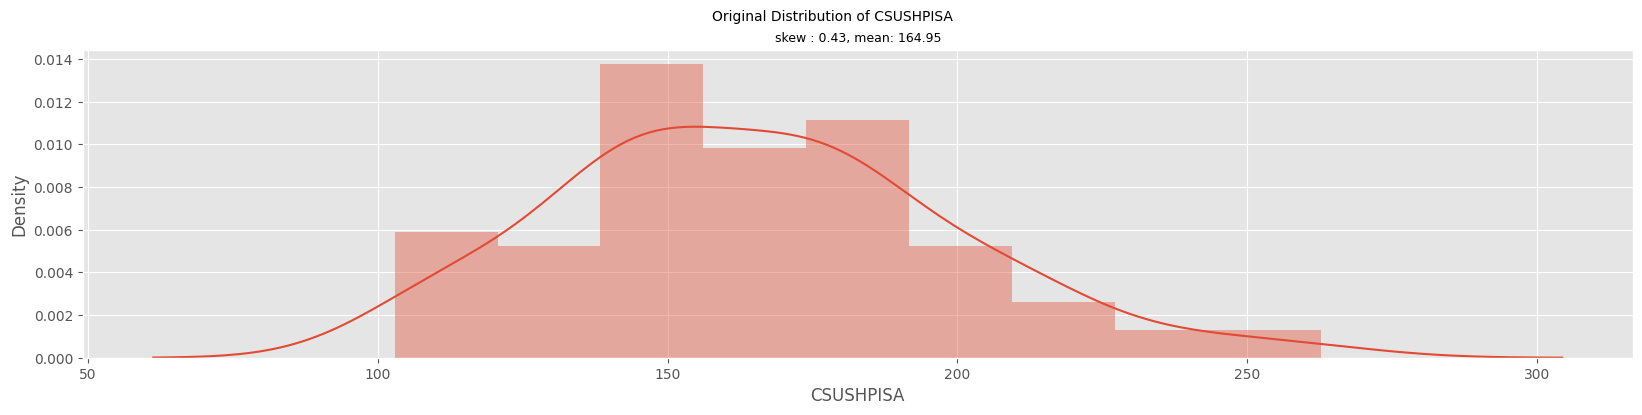

In [53]:
fig, ax = plt.subplots( figsize=(20, 4))
fig.suptitle('Original Distribution of CSUSHPISA', fontsize=10)

# Original Distribution and Boxplot
sns.distplot(df['CSUSHPISA'], ax=ax)
skew = np.round(stats.skew(df['CSUSHPISA']), 2)
ax.set_title(f'skew : {skew}, mean: {np.round(df["CSUSHPISA"].mean(),2)}',fontsize=9)

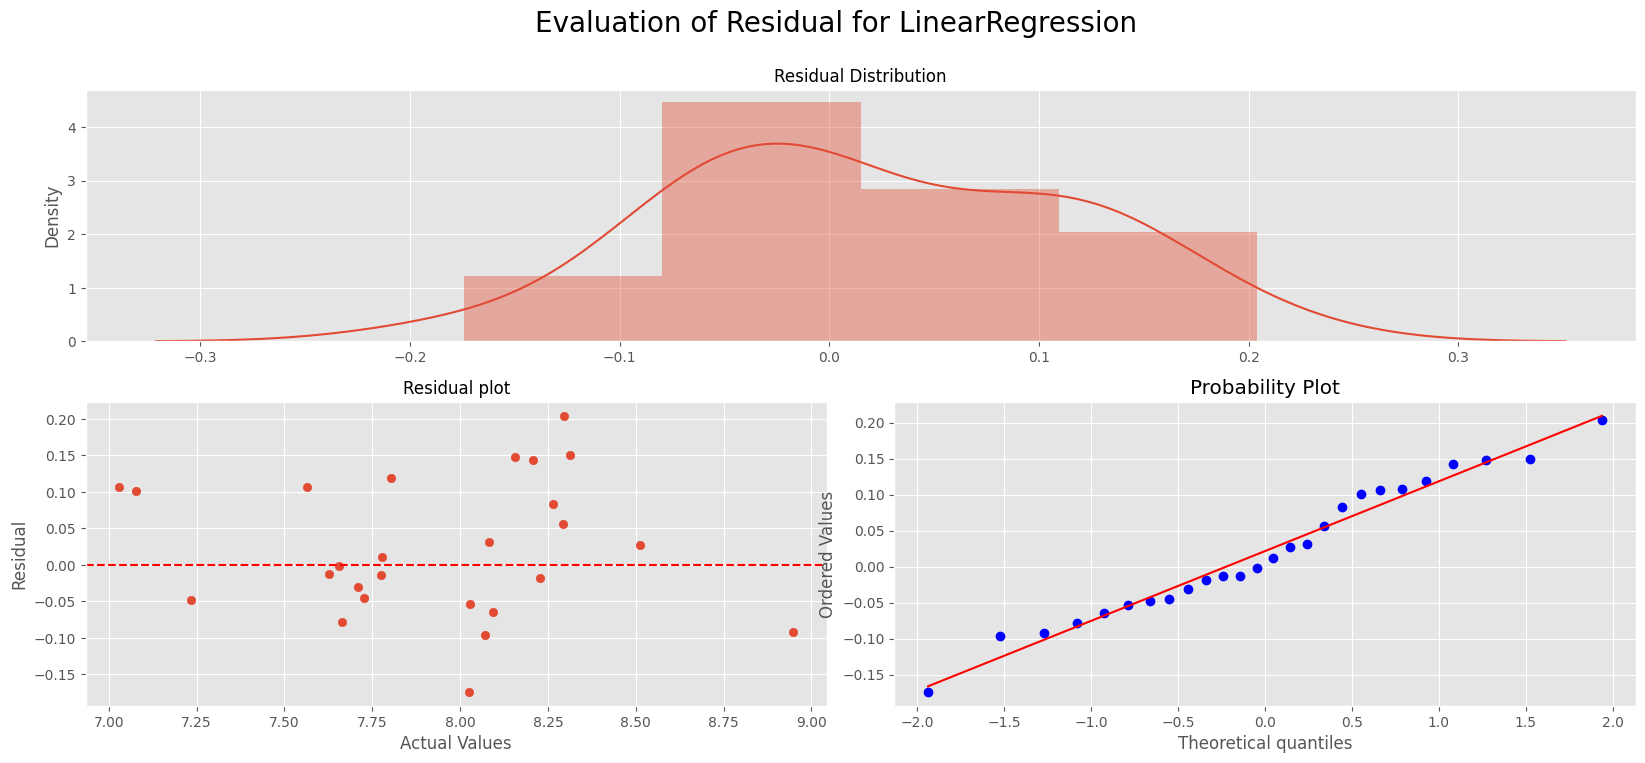

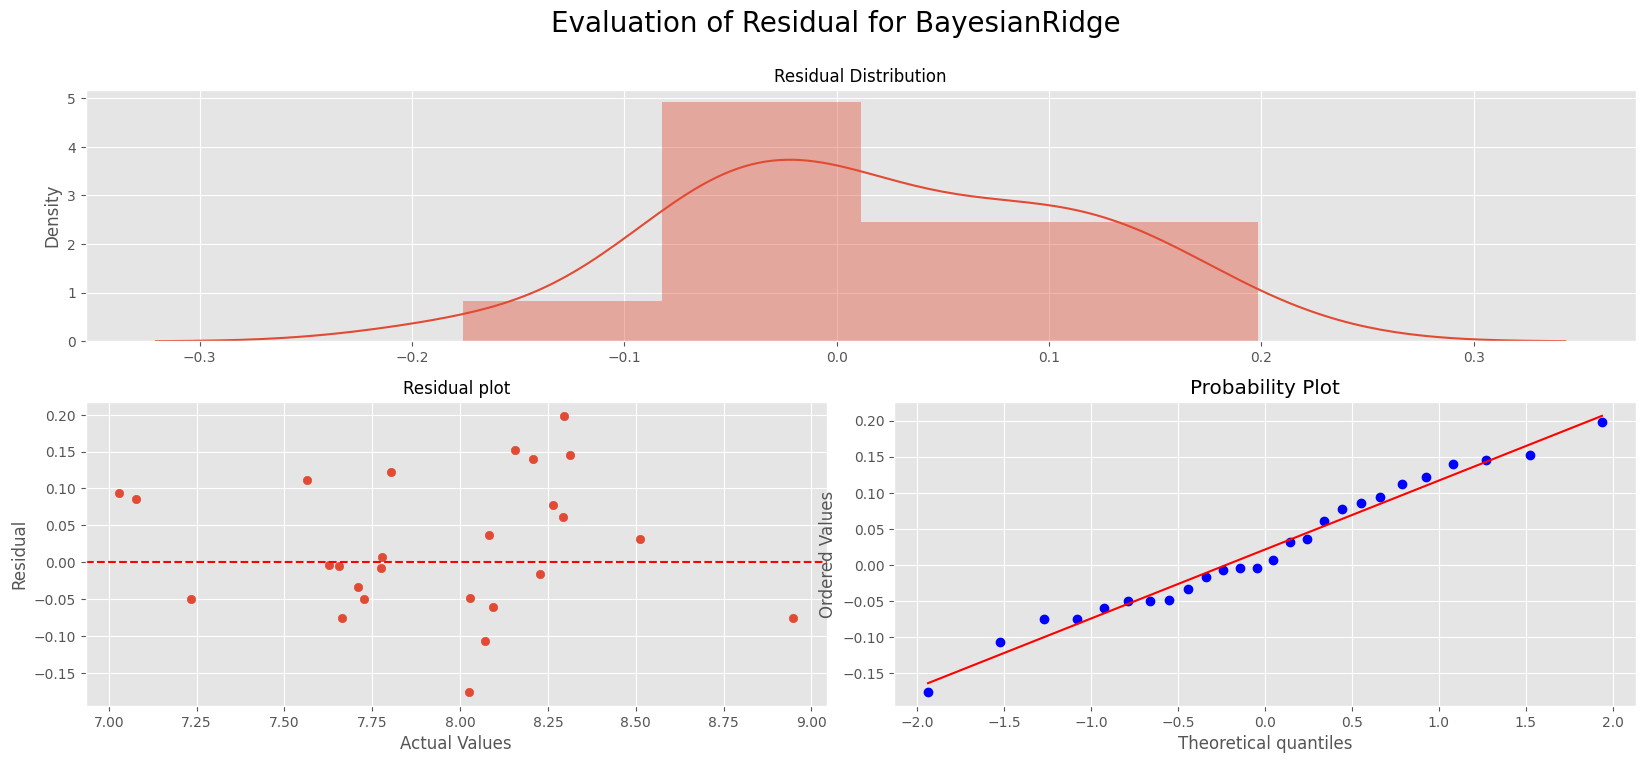

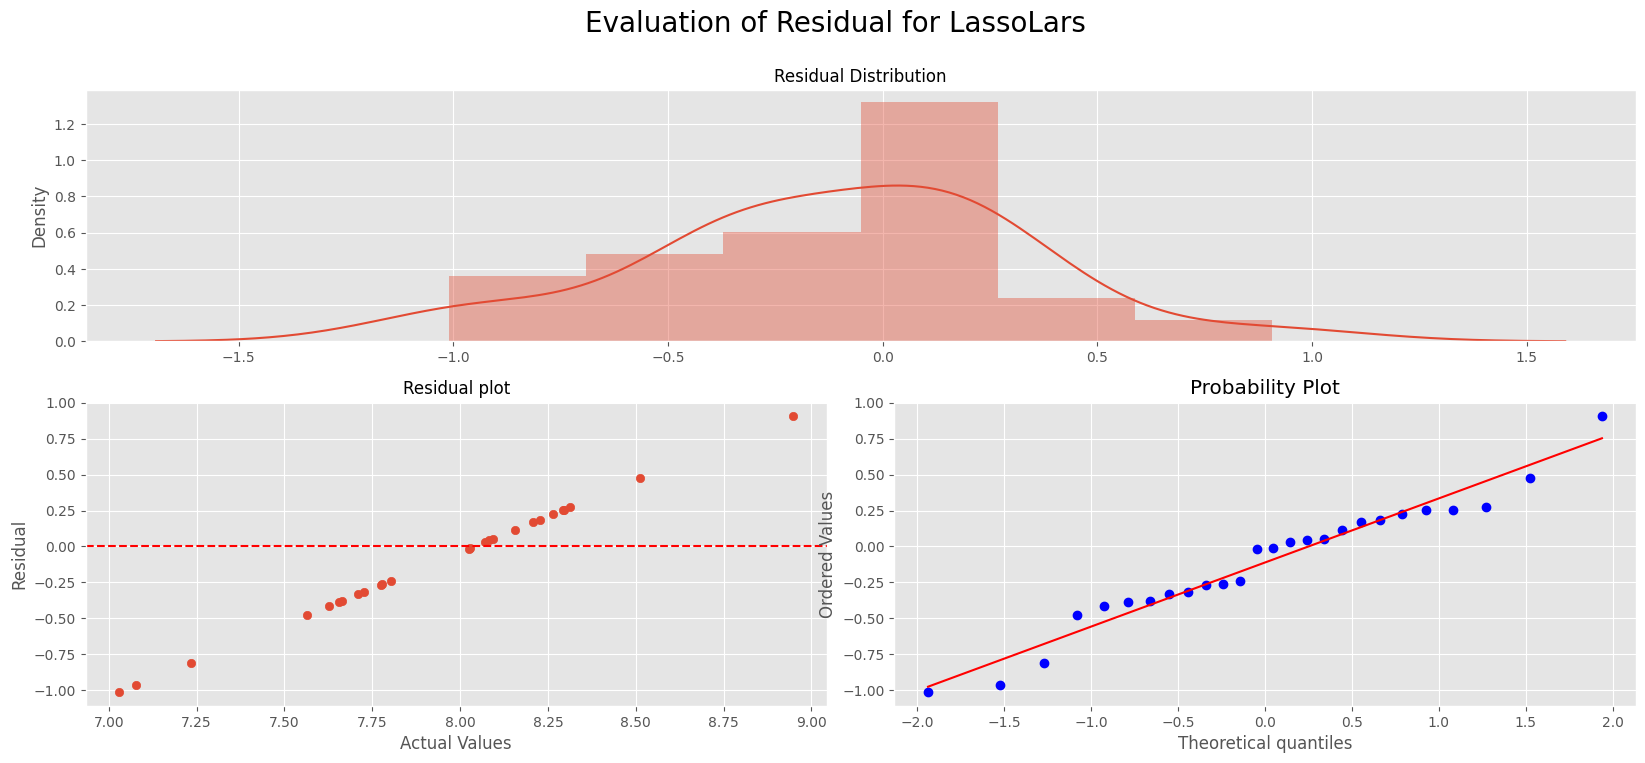

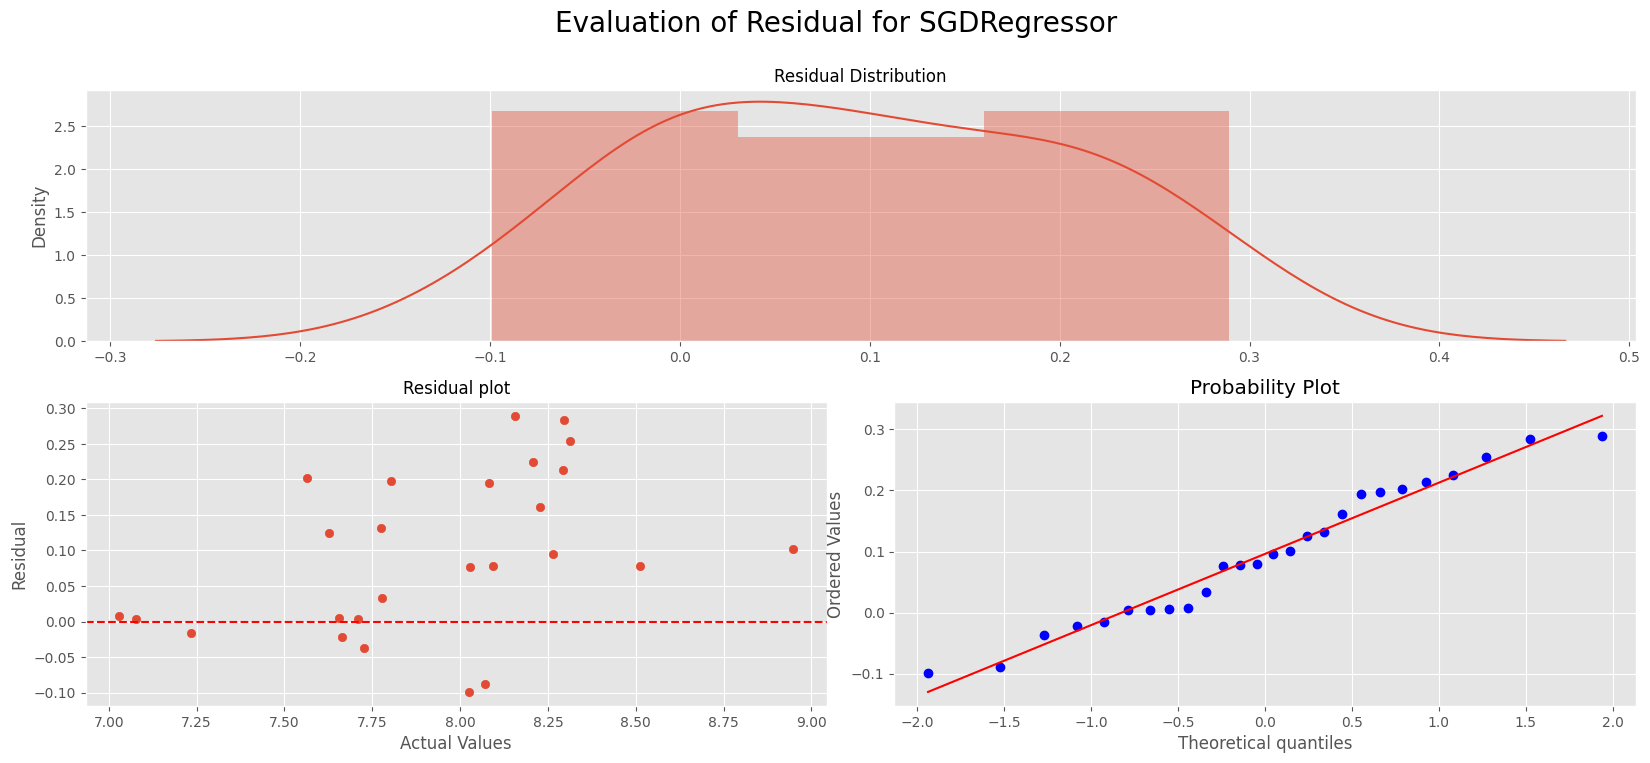

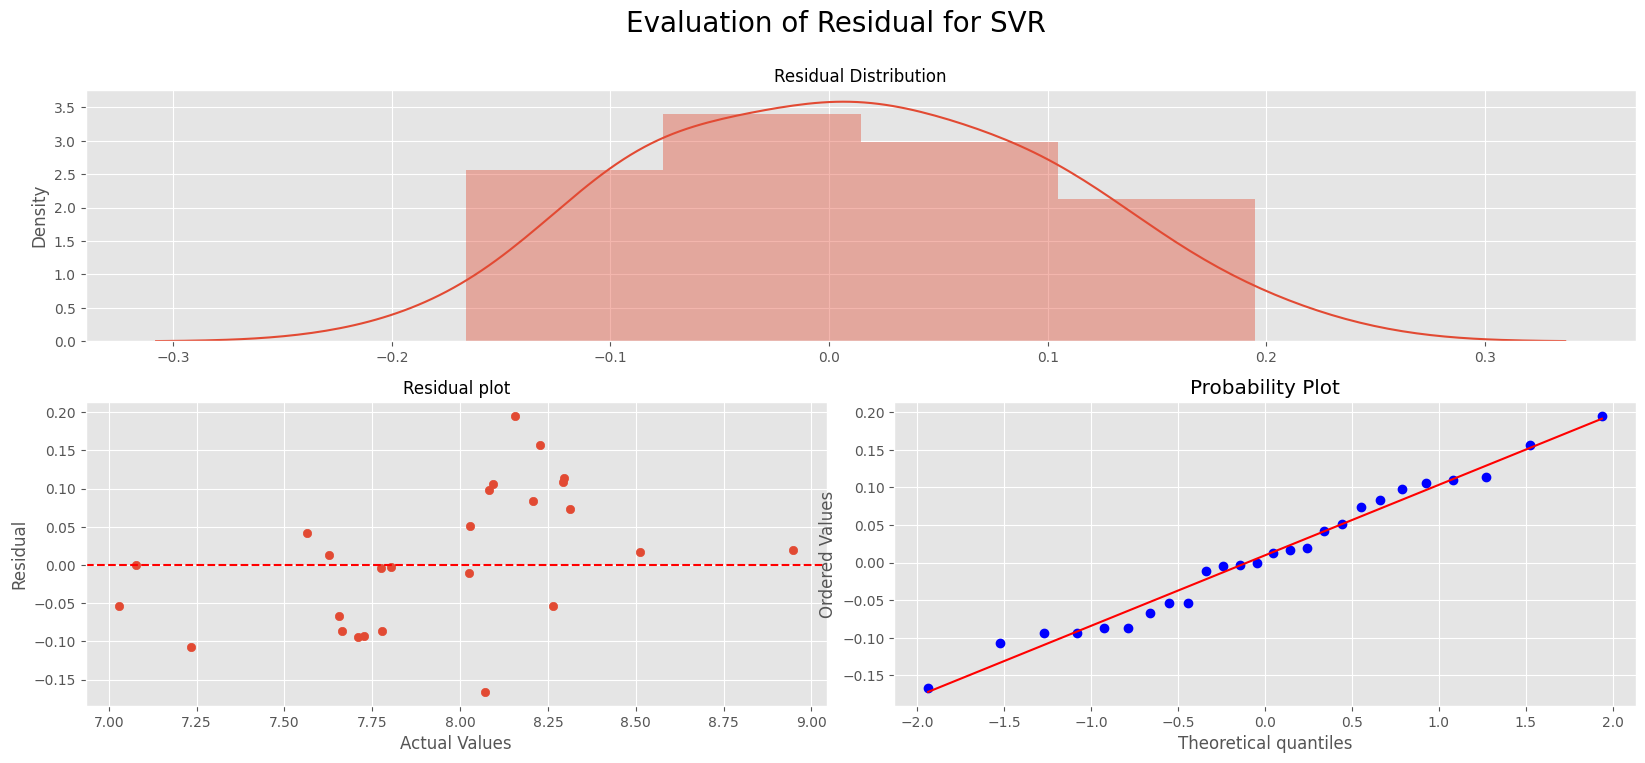

In [60]:
for result in results_list:
  fig = plt.figure(figsize=(20,8))
  fig.suptitle(f'Evaluation of Residual for {result["Model Name"]}',fontsize=20)

  gs = grid.GridSpec(ncols=4,nrows=12)

  ax1 = fig.add_subplot(gs[:5,:])
  ax1.set_title('Residual Distribution',fontsize=12)
  sns.distplot(result['Test Data Residual'],ax=ax1)


  ax2 = fig.add_subplot(gs[6:,:2])
  ax2.set_title('Residual plot',fontsize=12)
  ax2.scatter(y_test,result['Test Data Residual'])
  ax2.axhline(y=0,color='r',ls='--')
  ax2.set_xlabel('Actual Values')
  ax2.set_ylabel('Residual')

  ax2 = fig.add_subplot(gs[6:,2:])
  ax2.set_title('Probability plot',fontsize=12)
  stats.probplot(result['Test Data Residual'],plot=ax2)

  plt.show()

## Observation Of Model Development
<blockquote style="background-color: #f7dc6f; padding: 10px; border-radius: 5px;">
  <ul>
    <li><strong>Question: Why not use tree-based or deep neural network?</strong>
      <ul>
        <li>We do not want to draw decision boundaries because, as we saw while analyzing things like GDP, Median Sales, or Vacant, or any other aspect affects our Target columns.</li>
        <li>The point here is in the real world, we can't say things go as we expected. That's why we want our model to learn from real-time data observations and predict outcomes based on that.</li>
        <li>In tree-based models, we draw decision boundaries that are good for scenarios with limited possibilities.</li>
        <li>Then what is wrong with Neural Network? We want to know which factors affect more or less in predicting outcomes, which is not known if we work with neural networks.</li>
        <li>Hence, we go with Linear Models. The advantage is they are less complex, and we say there is a linear correlation between the target and independent columns.</li>
        <li>We are going to experement with `Linear Regressor` and `SVM` becuase they are best performers.</li>
      </ul>
    </li>
  </ul>
</blockquote>
